In [30]:
# work with saved historic data to minimize the number of api requests

import pandas as pd
import os

symbol = 'btc'

tick_data = pd.read_csv(symbol+'_daily.v.txt', index_col=2, infer_datetime_format=True, parse_dates=True)

#tick_data.iloc[:, 0] = pd.to_datetime(tick_data.iloc[:, 0], infer_datetime_format=True, unit='s')

#tick_data.set_index('time', inplace=True)

tick_data.sort_index(inplace=True)

tick_data.head

<bound method NDFrame.head of            <TICKER> <PER>  <TIME>       <OPEN>       <HIGH>        <LOW>  \
<DATE>                                                                     
2010-07-17    BTC.V     D       0      0.04951      0.04951      0.04951   
2010-07-18    BTC.V     D       0      0.04951      0.08585      0.04951   
2010-07-19    BTC.V     D       0      0.08584      0.09307      0.07723   
2010-07-20    BTC.V     D       0      0.08080      0.08181      0.07426   
2010-07-21    BTC.V     D       0      0.07474      0.07921      0.06634   
...             ...   ...     ...          ...          ...          ...   
2021-01-05    BTC.V     D       0  31361.18000  34486.79000  29997.68000   
2021-01-06    BTC.V     D       0  34304.01000  36477.93000  33417.00000   
2021-01-07    BTC.V     D       0  36073.46000  40335.15000  36052.83000   
2021-01-08    BTC.V     D       0  39700.86000  41945.44000  36696.09000   
2021-01-09    BTC.V     D       0  40729.42000  41394.9900

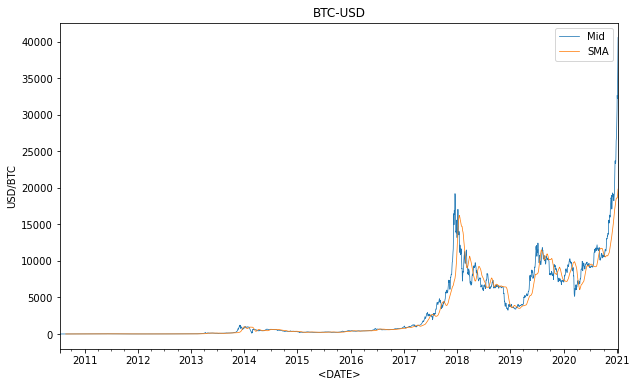

In [31]:
import time
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt

sub = tick_data.copy()

# analyze data sub-set

i = 20 # Number of ticks to use for simple moving average (SMA)

sub['Mid'] = sub.loc[:, ('<OPEN>','<CLOSE>')].mean(axis=1)
sub['SMA'] = sub.loc[:, 'Mid'].rolling(i).mean().shift(i)
sub[['Mid', 'SMA']].plot(figsize=(10,6), lw=0.75, title='BTC-USD', ylabel='USD/BTC')
plt.savefig('1-BTC-USD_SMA.png')
plt.show()

In [32]:
import pandas as pd
import numpy as np

# vectorized backtesting

ptc = 0.005 # proportional transactional costs - Coinbase Pro charges 0.5% per transaction

data = pd.DataFrame()
data['returns'] = np.log(sub['Mid']/sub['Mid'].shift(1))

data.dropna(inplace=True)

lags = 5

cols = []

for lag in range(1, lags+1):
    col = 'lag_{}'.format(lag)
    data[col] = data['returns'].shift(lag)
    cols.append(col)

data.dropna(inplace=True)

data[cols] = np.where(data[cols] > 0, 1, 0)

data['direction'] = np.where(data['returns'] > 0, 1, -1)

data[cols + ['direction']].head()

,lag_1,lag_2,lag_3,lag_4,lag_5,direction
<DATE>,,,,,,
2010-07-23,0.0,0.0,0.0,1.0,1.0,-1
2010-07-24,0.0,0.0,0.0,0.0,1.0,1
2010-07-25,1.0,0.0,0.0,0.0,0.0,-1
2010-07-26,0.0,1.0,0.0,0.0,0.0,1
2010-07-27,1.0,0.0,1.0,0.0,0.0,1


In [33]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

model = SVC(C=1, kernel='linear', gamma='auto')

split = int(len(data) * 0.80)

train = data.iloc[:split].copy()

model.fit(train[cols], train['direction'])

SVC(C=1, gamma='auto', kernel='linear')

In [34]:
accuracy_score(train['direction'], model.predict(train[cols]))

0.6619810395554102

In [35]:
test = data.iloc[split:].copy()

test['position'] = model.predict(test[cols])

In [36]:
accuracy_score(test['direction'], test['position'])

0.6483660130718955

In [37]:
test['strategy'] = test['position'] * test['returns']
sum(test['position'].diff() != 0)

270

In [38]:
test['strategy_tc'] = np.where(test['position'].diff() != 0, test['strategy'] - ptc, test['strategy'])

In [39]:
test[['returns', 'strategy', 'strategy_tc']].sum().apply(np.exp)

returns          10.999141
strategy       1193.688027
strategy_tc     309.451995
dtype: float64

<AxesSubplot:xlabel='<DATE>'>

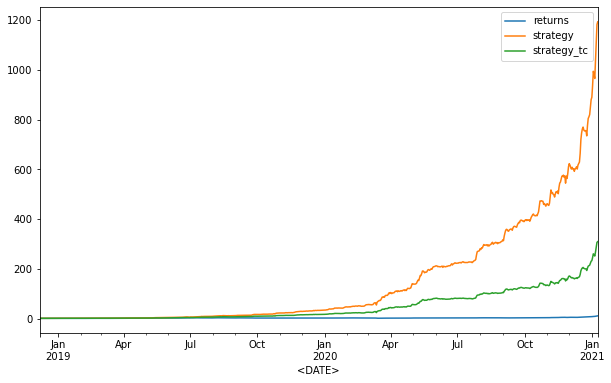

In [40]:
test[['returns', 'strategy', 'strategy_tc']].cumsum().apply(np.exp).plot(figsize=(10,6))

In [41]:
import pandas as pd
test.to_csv('backtest_daily_2021-01-10.csv')

In [43]:
import pickle

pickle.dump(model, open('algorithm_dailyBTC.pkl', 'wb'))